# Forecasting temperature with SARIMA
## Abstract
The aim for this project is to find an appropriate model able to forecast monthly mean air temperature in Stockholm. 

# Introduction

> Temperature forecasting is a challenging but important task. The areas in need of accurate forecasting are many, ranging from agriculture to energy consumption. An increase in air temperature would also lead to sea-level rise, global warming and will negatively impact humans. 

> In this notebook, air temperature in Stockholm was modeled by Seasonal Autoregressive Moving Average (SARIMA).


https://irjabs.com/files_site/paperlist/r_449_121110152548.pdf

http://www.statistics.du.se/essays/D09_Xier_Li.pdf

http://www.statistics.du.se/essays/D08D_XiangJunquan.pdf

In [46]:
library(ggplot2);
library(plotly);
library(ggfortify);
library(repr);
library(tidyr);
library(tsibble);
library(TSstudio);
library(zoo);
library(dplyr)

library(ggridges)
library(viridis)
library(hrbrthemes)

Sys.setlocale(locale = "English");


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

https://bolin.su.se/data/stockholm-historical-monthly-temperature-3?n=stockholm-historical-temps-monthly-3

# Data source
The data consist out of 36 years of monthly mean air temperatures. 

In [2]:
dataset = read.csv("dataset/train_stockholm_monthly_mean_temperature.csv", sep=';')
#rownames(dt) = as.integer(as.character(dt$year))
min_year = min(dataset$year)
max_year = max(dataset$year)
#dt = dt[,-1]
head(dataset)

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980,-4.7,-6.2,-3.1,4.8,7.8,15.6,16.8,14.6,12.8,5.7,0.0,-0.8
2,1981,-4.0,-2.7,-2.2,3.9,10.8,12.6,16.4,14.6,11.7,6.5,1.1,-5.7
3,1982,-7.2,-4.0,1.1,4.1,9.4,12.5,17.4,17.0,12.3,7.6,4.5,0.3
4,1983,0.7,-3.8,-0.1,4.0,10.2,14.0,18.0,17.8,12.4,7.5,1.2,-1.1
5,1984,-3.0,-1.7,-2.0,5.3,10.9,13.3,15.3,16.4,10.6,8.9,4.3,0.8
6,1985,-9.0,-11.6,-1.7,1.6,9.0,13.6,15.9,15.4,10.3,8.0,0.3,-4.3


In [35]:
train = ts(as.vector(t(as.matrix(dataset[,-1]))), start=c(1980, 1), end=c(max_year, 12), frequency =12)

In [4]:
train_reshape <- data.frame(date=as.Date(as.yearmon(time(train))), temp=as.matrix(train))

train_reshape$month <- format(train_reshape$date, "%b")
train_reshape$year <- format(train_reshape$date, "%Y")

head(train_reshape)

,date,temp,month,year
,<date>,<dbl>,<chr>,<chr>
1,1980-01-01,-4.7,Jan,1980
2,1980-02-01,-6.2,Feb,1980
3,1980-03-01,-3.1,Mar,1980
4,1980-04-01,4.8,Apr,1980
5,1980-05-01,7.8,May,1980
6,1980-06-01,15.6,Jun,1980


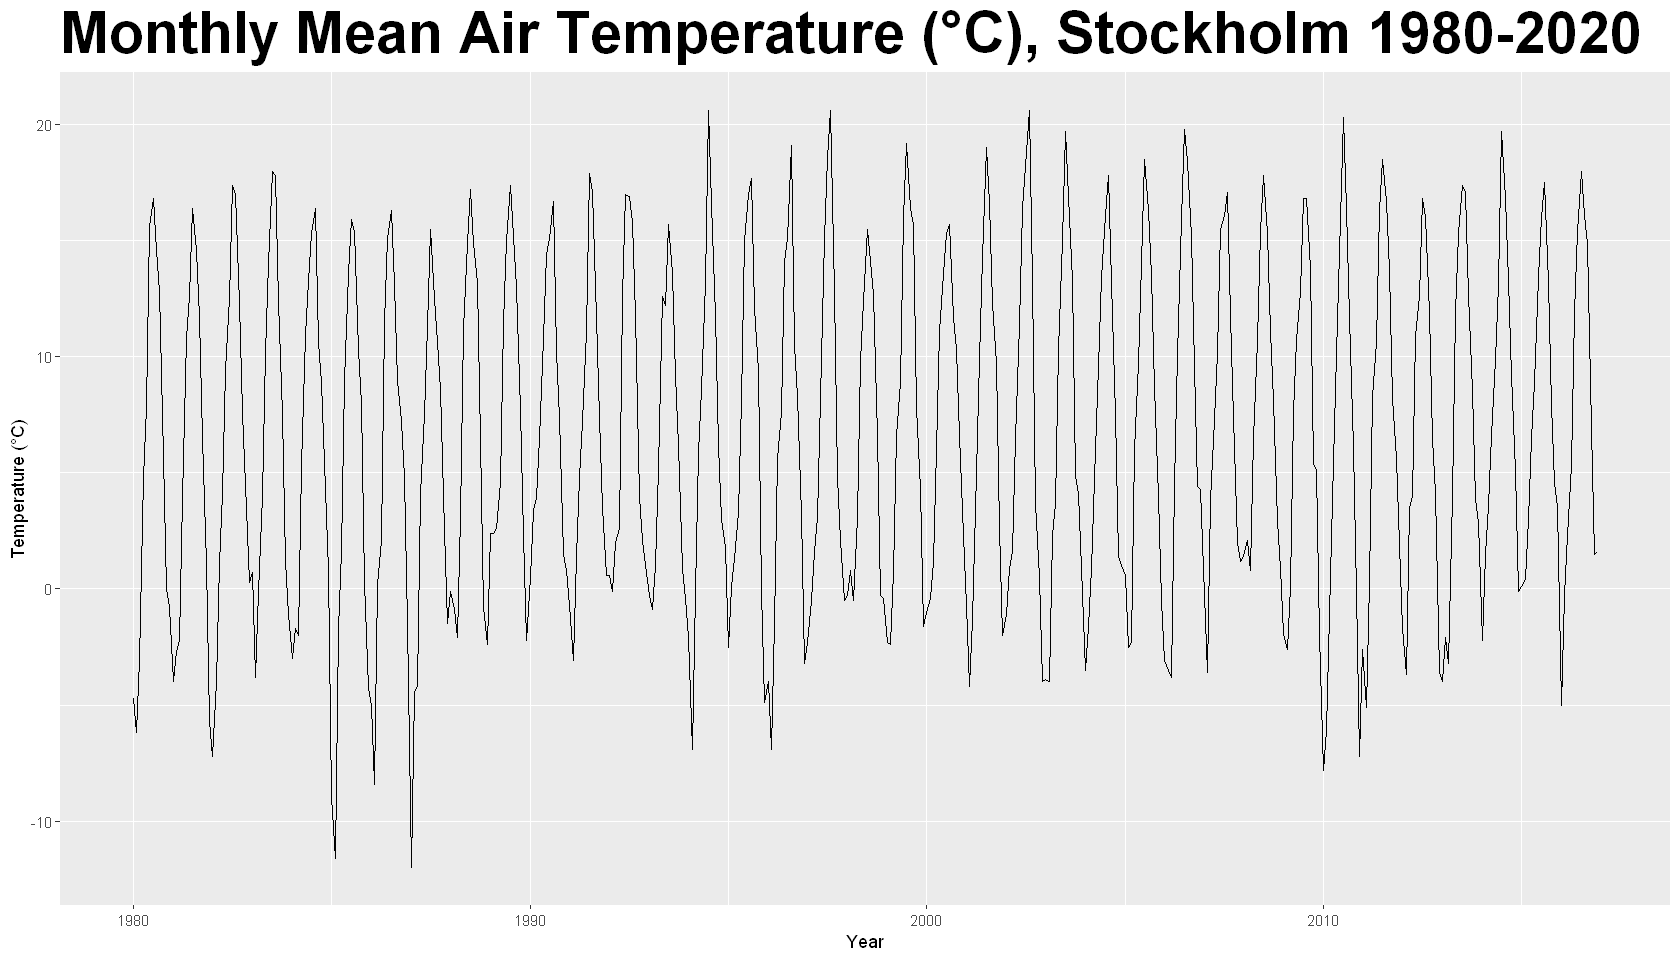

In [5]:
options(repr.plot.width=14, repr.plot.height=8)
autoplot(train, xlab="Year", ylab="Temperature (°C)")+
    ggtitle("Monthly Mean Air Temperature (°C), Stockholm 1980-2020")+ 
    theme(plot.title = element_text(size = 35, face = "bold")) +
    guides(colour = guide_legend(title.hjust = 20))

> Ridgeline plot. Potential outliers in January and February. 

Picking joint bandwidth of 0.787



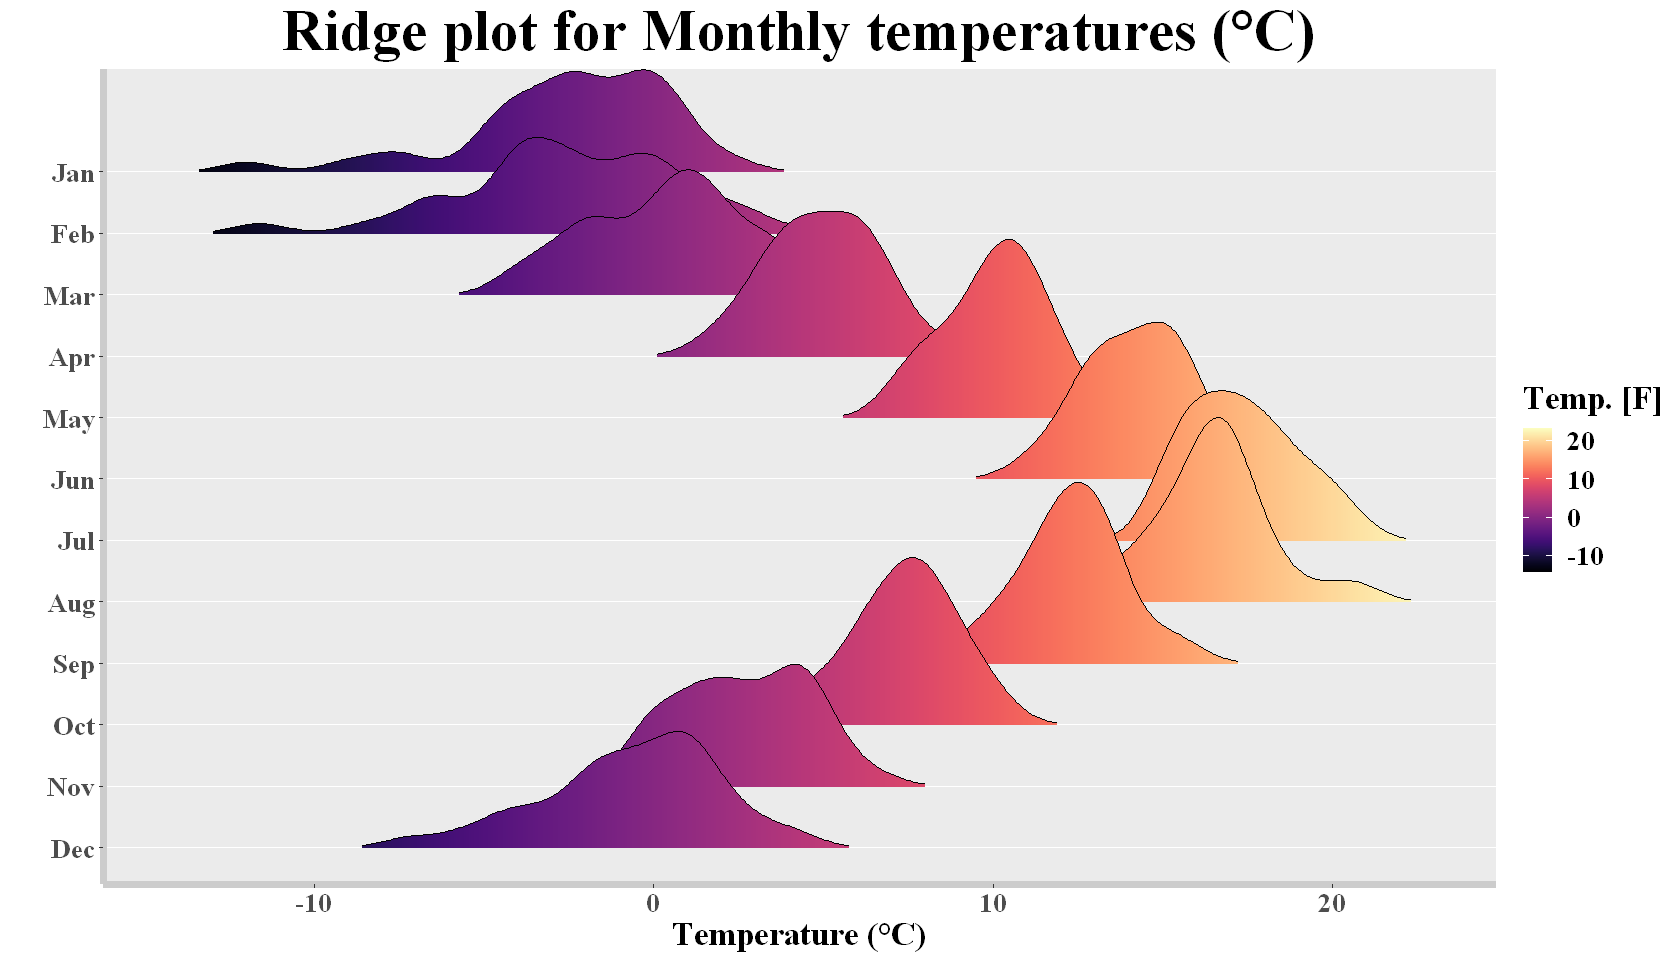

In [6]:
ggplot(train_reshape, aes(x = temp, y = factor(month, levels = month.abb), fill = ..x..)) +
    geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01) +
    scale_fill_viridis(name = "Temp. [F]", option = "A") +
    labs(title = 'Ridge plot for Monthly temperatures (°C)') +
    scale_y_discrete(limits=rev) +
    xlab("Temperature (°C)") + ylab("") +
    theme(text=element_text(size = 20, face = "bold",  family="serif"),
        plot.title = element_text(size = 35, face = "bold",  family="serif", hjust = 0.5),
        axis.line = element_line(size = 2, colour = "grey80"),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank())

In [7]:
#fig <- plot_ly(train_reshape , x = ~date, y = ~temp, type = 'scatter', mode = 'lines') %>%
#        layout(title = 'Monthly Mean Air Temperature (°C)', plot_bgcolor = "#e5ecf6")
#fig

In [17]:
heatmap(train_reshape[,c(4,3,2)])

ERROR: Error in heatmap(train_reshape[, c(4, 3, 2)]): 'x' must be a numeric matrix


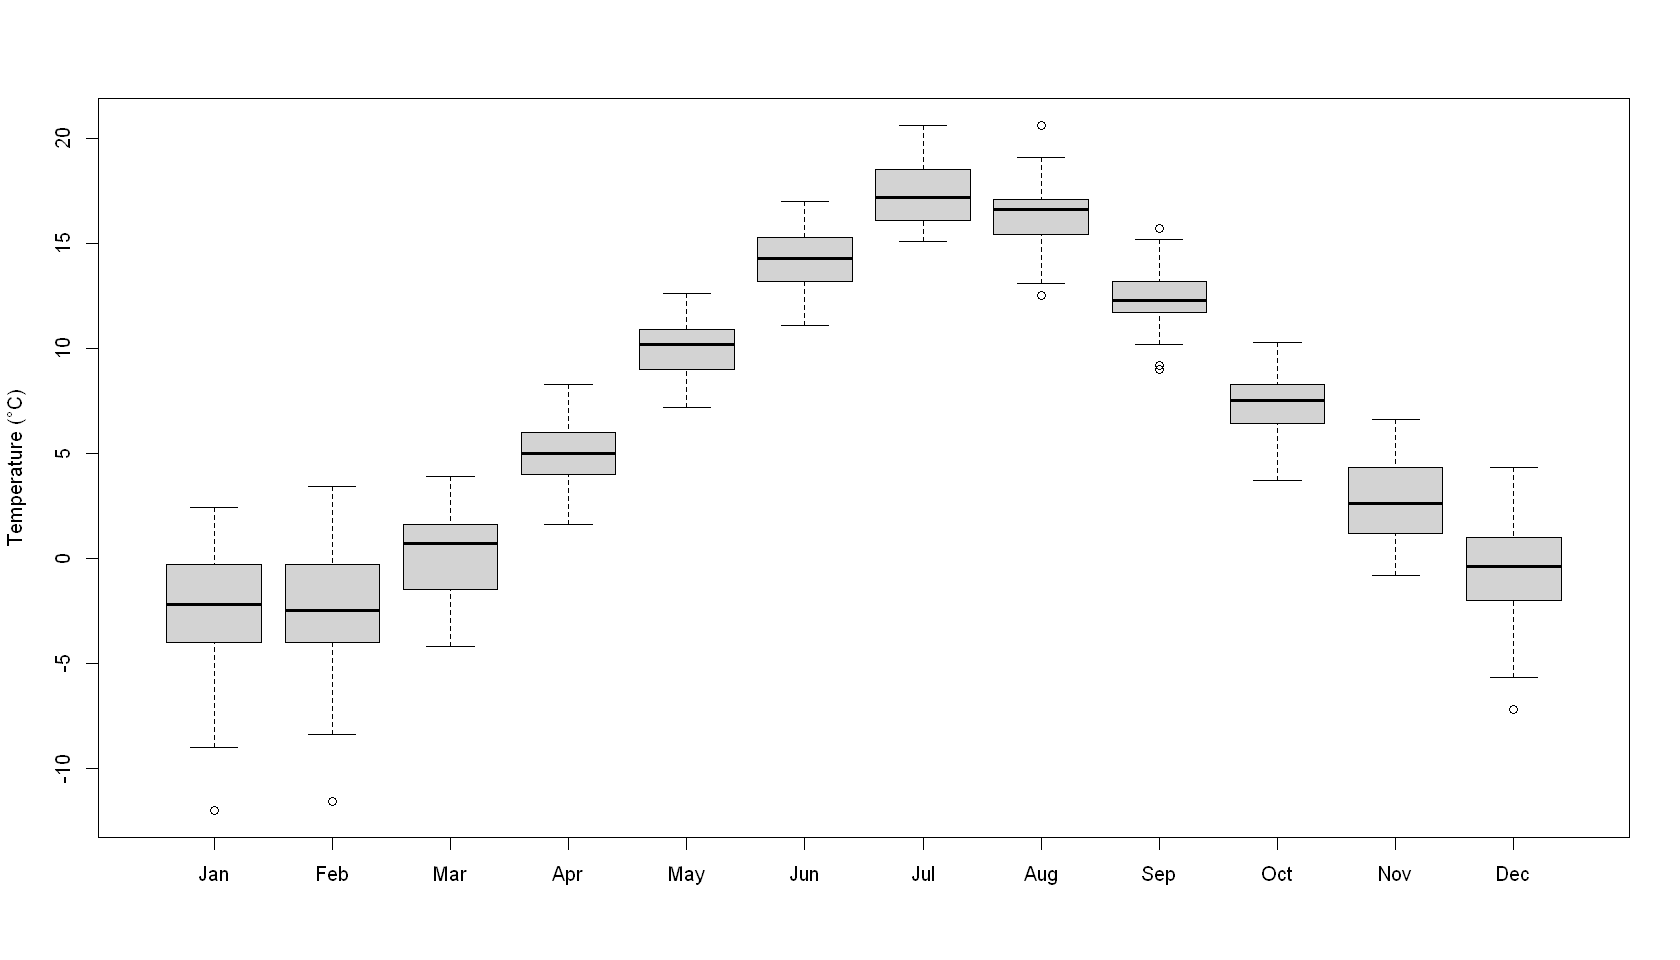

In [18]:
boxplot(train~cycle(train), names=month.abb, xlab="", ylab="Temperature (°C)")

For example, a root near 1 of the autoregressive polynomial suggests that the data
should be differenced before fitting an ARMA model, whereas a root near 1 of
the moving-average polynomial indicates that the data were overdifferenced.

In [19]:
library(tseries)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



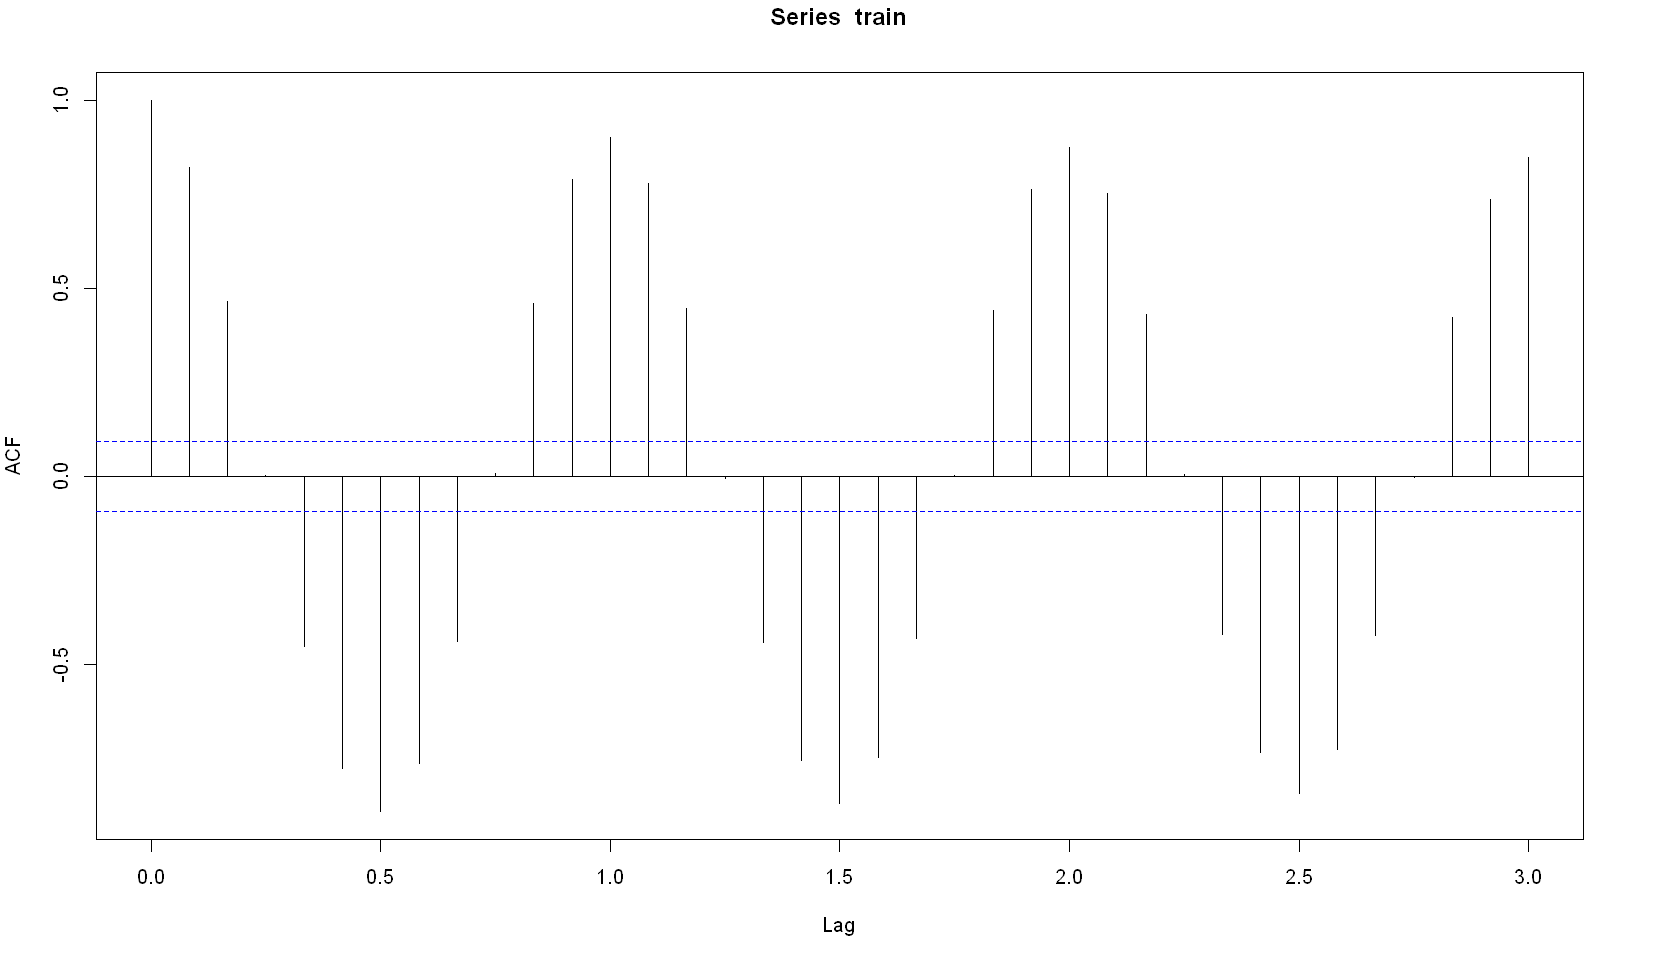

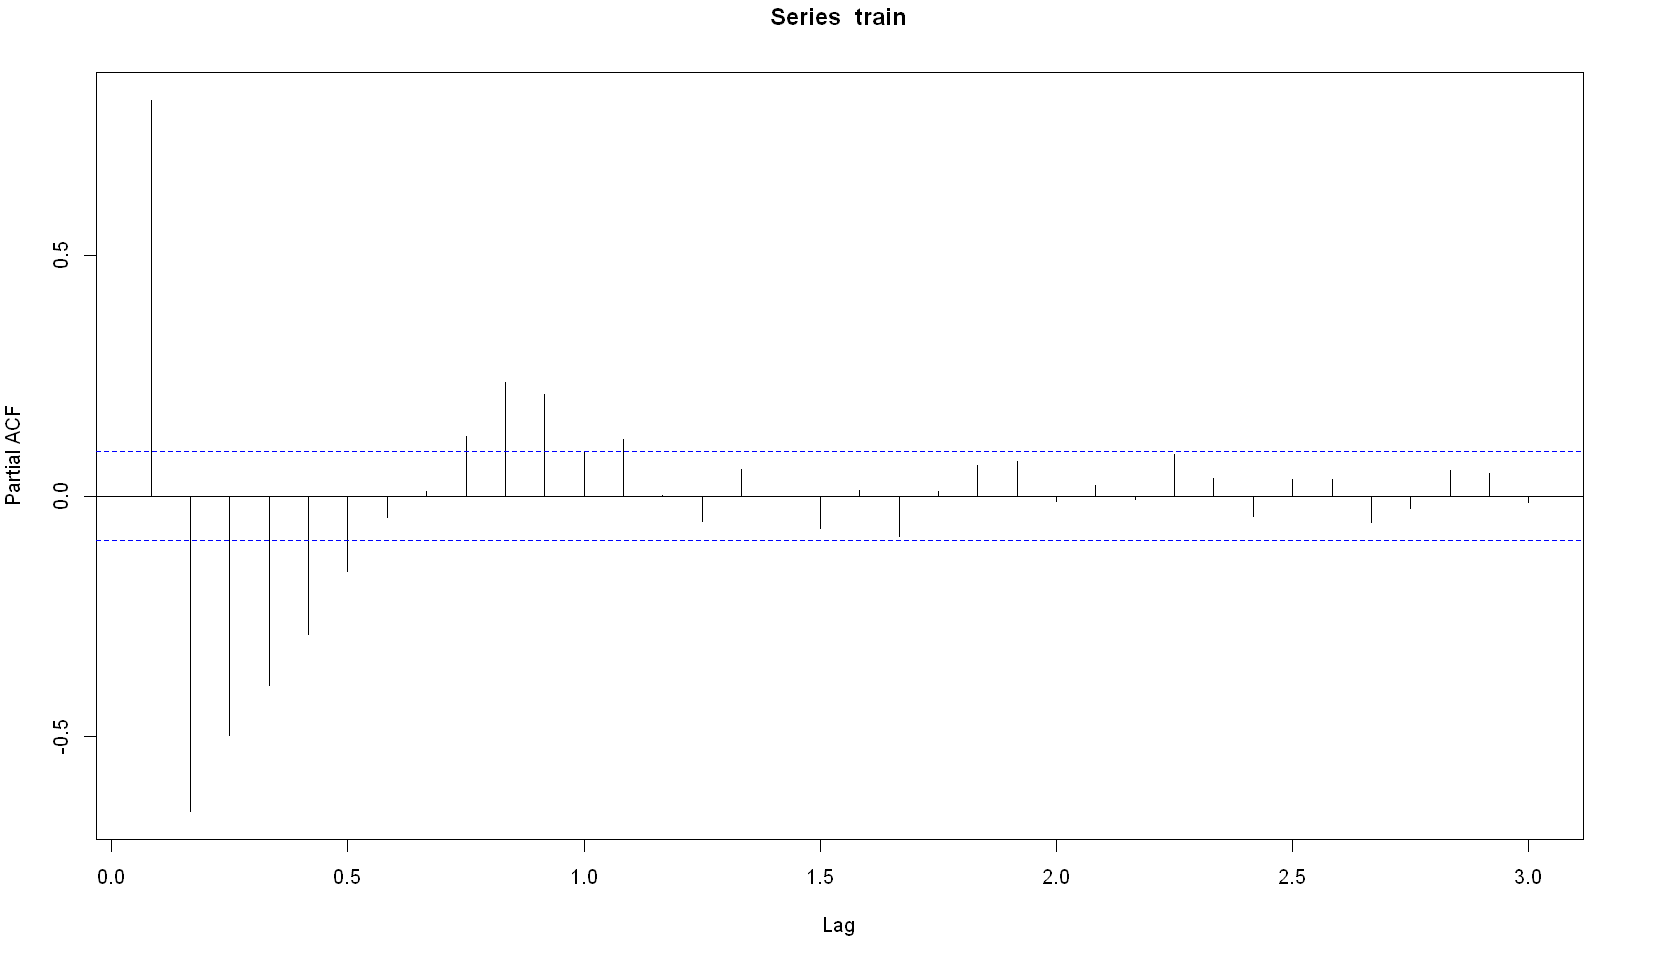

In [26]:
par(mar=c(5,4,3,4))
acf(train, lag.max = 36)
pacf(train, lag.max = 36)

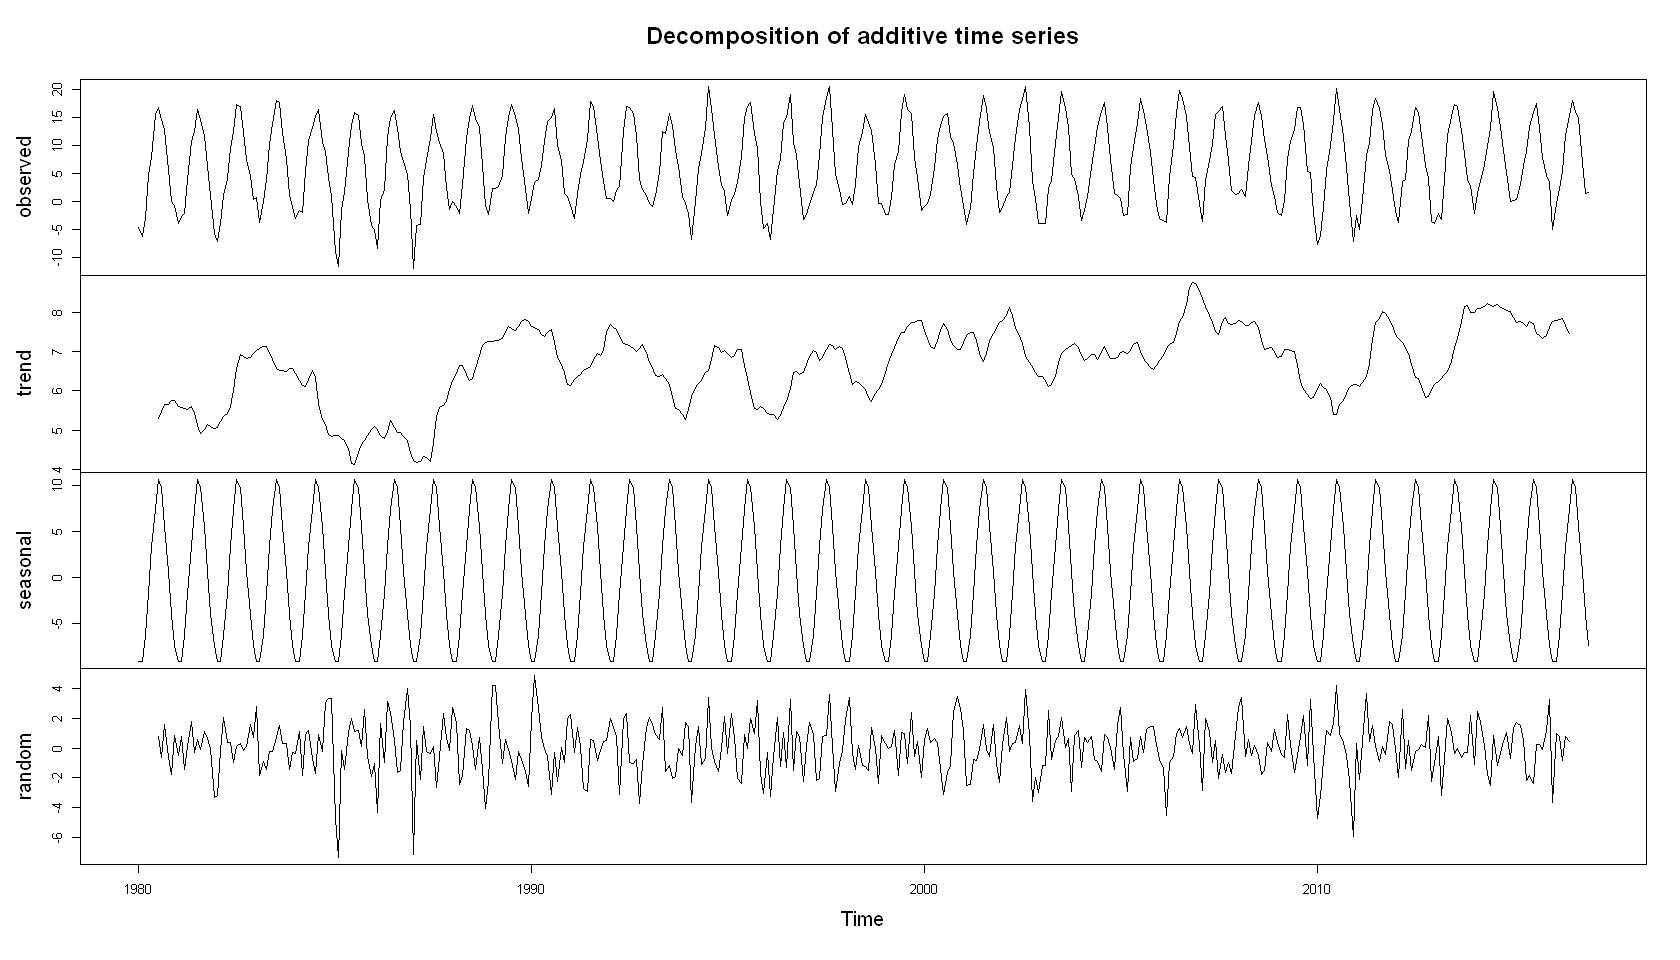

In [29]:
decomp = decompose(train)
plot(decomp)

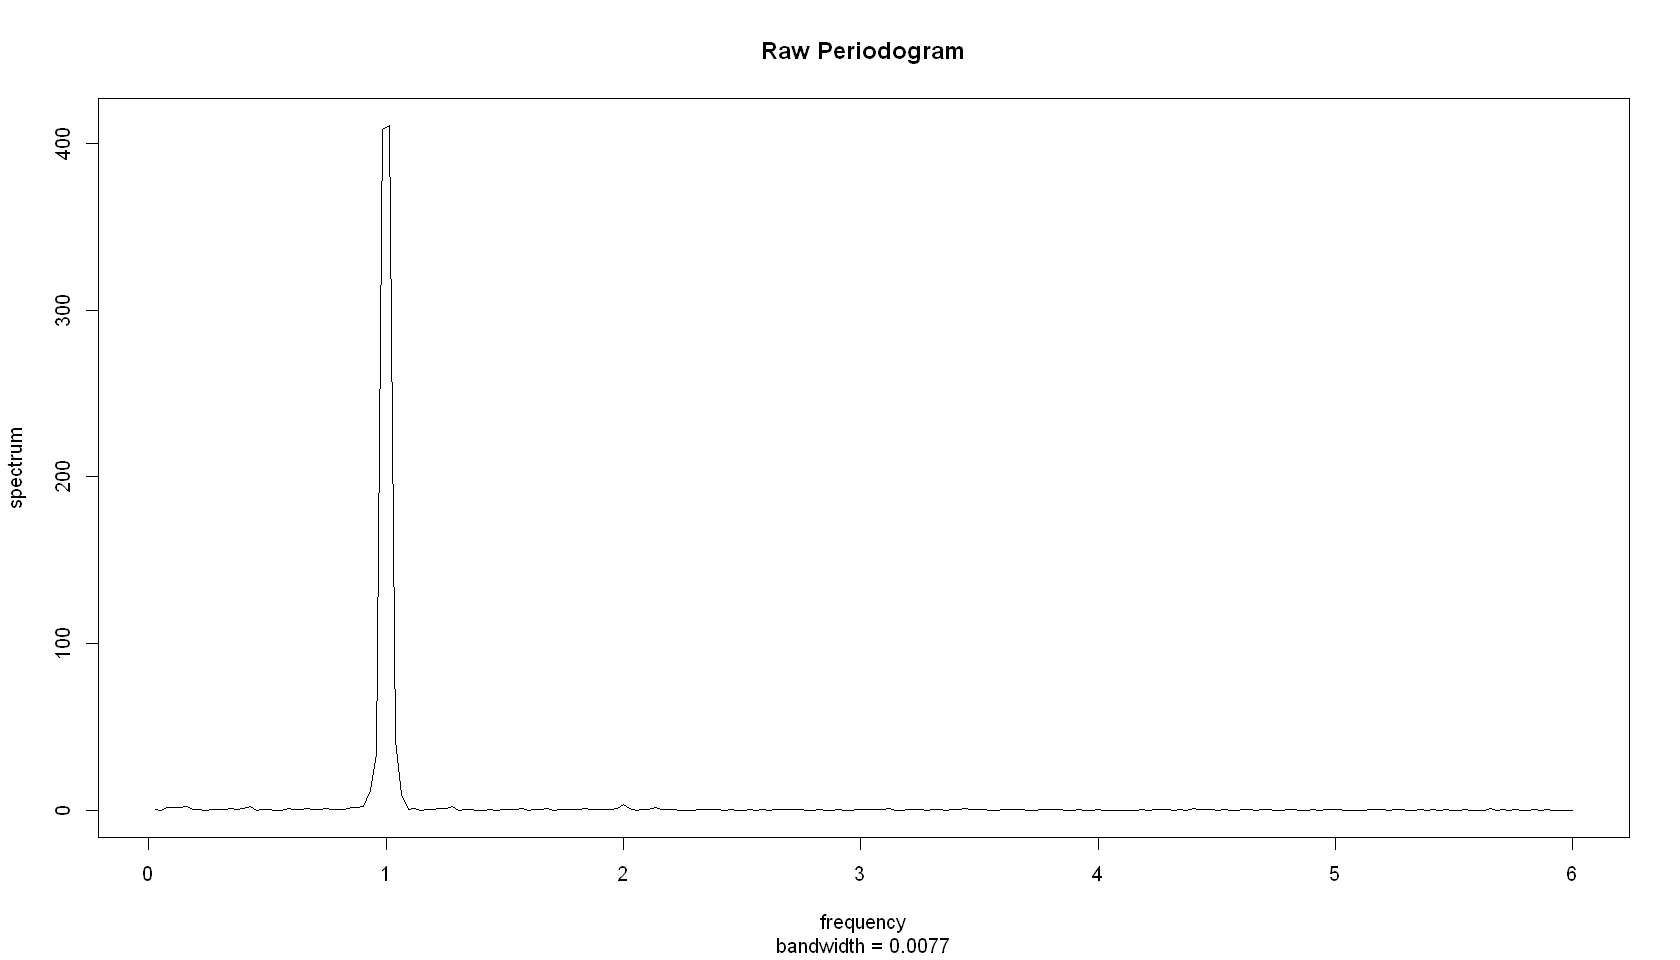

In [30]:
spec.pgram(train, log="no", main="Raw Periodogram")

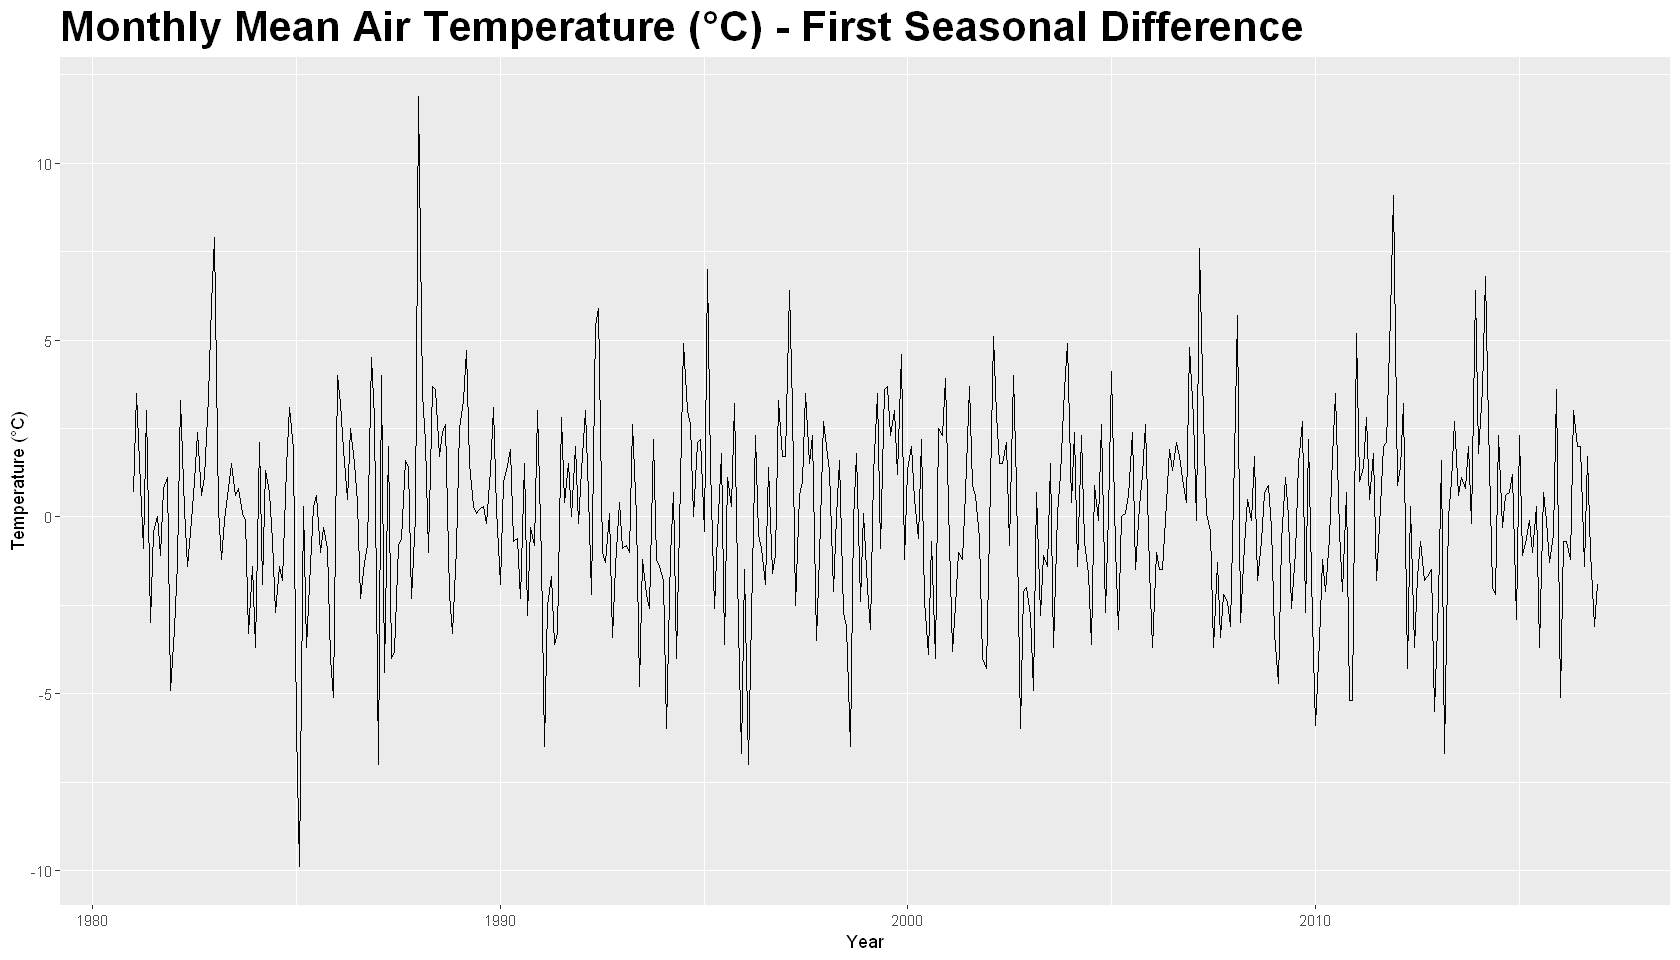

In [40]:
# Seasonal difference
train.diff = diff(train, lag=12)

autoplot(train.diff, xlab="Year", ylab="Temperature (°C)")+
    ggtitle("Monthly Mean Air Temperature (°C) - First Seasonal Difference")+ 
    theme(plot.title = element_text(size = 25, face = "bold")) +
    guides(colour = guide_legend(title.hjust = 20))

In [41]:
adf.test(train.diff)

Warning message in adf.test(train.diff):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train.diff
Dickey-Fuller = -6.5205, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [42]:
kpss.test(train.diff)

Warning message in kpss.test(train.diff):
"p-value greater than printed p-value"



	KPSS Test for Level Stationarity

data:  train.diff
KPSS Level = 0.021325, Truncation lag parameter = 5, p-value = 0.1


In [57]:
p <- q <- P <- Q <- 0:3

grid <- expand.grid(p, q, P, Q)
grid$d <- 0
grid$D <- 1
grid$k <- rowSums(grid)
grid <- grid %>% filter(k<=8)